In [58]:
import pandas as pd
#from utils import randomSplit, Accumulator
#import torch
#from torch import nn
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler   # 归一化
from sklearn.model_selection import KFold         # k折交叉验
from sklearn.decomposition import PCA             # pca


#import modules
import kmapper as km
import umap
import sklearn
import sklearn.manifold as manifold

import matplotlib.pyplot as plt
from kmapper.jupyter import display

from sklearn.decomposition import PCA
from sklearn import cluster
import networkx as nx
from sklearn.decomposition import FactorAnalysis

import community  # louvain 算法

from scipy import stats  # 统计检验


In [154]:
def numpy_cos(a,b):
    '''求解cos相似度'''
    a = a / np.linalg.norm(a, axis=1).reshape(-1, 1)  # 先renorm，然后相乘就是cos
    b = b / np.linalg.norm(b, axis=1).reshape(-1, 1)
    dot = np.dot(a, b.T) #对应原始相乘dot.sum(axis=1)得到内积
    return dot

class myDataset():
    def __init__(self, renorm=False, pca=False, savehtml=False, **kargs):
        self.player = pd.read_csv('datacleaning/modified_data.csv', header=0, encoding='unicode_escape', delimiter=';')
        #self.player = self.player.drop(['Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Age', 'Born'], axis=1)
        
        # Squad 和 Season 需要保留
        #self.player = self.player.drop(['Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Age', 'Born'], axis=1)
        
        if renorm:
            scaler = StandardScaler()  # z score 归一化
            #scaler = MinMaxScaler()    # 0-1 归一化
            for col in self.player.columns:
                if col in ('Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Age', 'Born', 'Squad'): continue
                self.player[[col]] = scaler.fit_transform(self.player[[col]])
        if pca:
            squad = self.player['Squad']
            season = self.player['Season']
            pos = self.player['Pos']
            values = self.player.drop(['Squad', 'Season'], axis=1).values
            comp_dim = kargs['pca_dim']
            pca = PCA(n_components=comp_dim)   # 15
            values = pca.fit_transform(values)
            # print(sum(pca.explained_variance_ratio_))
            self.player = pd.DataFrame(values)
            self.player['Squad'] = squad
            self.player["Season"] = season
            self.player['Pos'] = pos

        #self.league = pd.read_excel('DLdata/SquadPerformance2021.xlsx', sheet_name='Sheet1')
        #self.league['tier'] = self.league.apply(rank2class, axis=1)
        #self.league = self.league[['Squad', 'Season', 'tier']]       

        #initialize mapper
        mapper = km.KeplerMapper(verbose=0)
        #project data
        self.X_features_numeric = self.player.drop(['Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Age', 'Born', 'Squad'], axis=1).values  # data array
        # 不确定是否要讲这些操作放在mapper的部分，不确定是否会变得更好，尝试一下
        # 修改本部分记得跑到上面的renorm那里，修改scaler的值
        # 结论：-> 大差不差
        '''self.X_features_numeric = np.log(self.X_features_numeric + 1)  # 在这里都取对数了
        scaler2 = StandardScaler()
        self.X_features_numeric = scaler2.fit_transform(self.X_features_numeric.T)
        self.X_features_numeric = self.X_features_numeric.T'''
        
        
        
        self.index2col = list(self.player.drop(['Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Age', 'Born', 'Squad'], axis=1).columns)  # 将 values 的列id转化为对应的col名称
        projected_X = mapper.fit_transform(self.X_features_numeric, 
                                            projection = [PCA(n_components=10),   #manifold.Isomap(n_components=10, n_jobs=-1),
                                                            umap.UMAP(n_components=3, random_state=1)], scaler=[None])  
        graph2 = mapper.map(projected_X, cover=km.Cover(n_cubes=10, perc_overlap=0.4),
                clusterer=sklearn.cluster.KMeans(n_clusters=5, random_state=1618033))
        
        # 生成主成分因子
        fa = FactorAnalysis(n_components=15, rotation='varimax')
        # 拟合数据并进行因子分析
        self.X_pca_features = fa.fit_transform(self.X_features_numeric)
        #print(np.sum(fa.components_ ** 2, axis=1))
        #print(np.sum(fa.components_ ** 2))
        # 打印因子载荷矩阵
        #print("Factor Loadings: ")
        for i in range(15):
            factor_load = fa.components_[i,:]
            big5_ids = np.argsort(np.abs(factor_load))[-1:-7:-1]
            #print(f'factor{i+1}: ', end='')
            #print(';'.join([f'{self.index2col[id]} {factor_load[id]:.2f}' for id in big5_ids]))
        #print(fa.components_.shape)
        # 打印降维后的结果
        #print("Factor Analysis Result:")
        #print(fa_result.shape)
        

        # 根据标签数据y创建对应的color_values
        def create_color_values(y):
            unique_labels = np.unique(y)
            color_values = [str(i + 1) for i in range(unique_labels.shape[0])]
            label_to_color = dict(zip(unique_labels, color_values))
            return np.array([label_to_color[label] for label in y])
        def node_color_func(node):
            labels, counts = np.unique(node, return_counts=True)
            max_count_index = np.argmax(counts)
            ans = create_color_values(labels)
            return ans[max_count_index] 
        self.pos = np.array(self.player['Pos'])
        
        self.graph = km.adapter.to_nx(graph2)
        colorvaluepos = create_color_values(self.pos)
        self.closeCenResult = nx.closeness_centrality(self.graph)  # returns dict
        clusters = self.graph.nodes.data()
        colorvalueCloseCen = [[] for i in range(colorvaluepos.shape[0])]
        self.cluster_features = dict()       # 所有变量的特征
        self.cluster_pca_features = dict()   # 15个主成分因子的特征
        for clusterdata in clusters:  # nx nodes view
            # 单个cluster example ('cube0_cluster0', {'membership': [2234, 3793, 5864, 6229, 8196]})
            clus_name = clusterdata[0]
            clus_closeCen = self.closeCenResult[clus_name]
            
            members_l = clusterdata[1]['membership']
            for member in members_l:  # id = dataframe里的index
                colorvalueCloseCen[member].append(clus_closeCen)
            # 生成cluster的特征，先取出对应的menber 的feature，再求平均
            cur_cluster_feature = self.X_features_numeric[np.array(members_l), :].mean(axis=0)  # shape [1, self.cluster_features_dim]
            cur_cluster_pca_feature = self.X_pca_features[np.array(members_l), :].mean(axis=0)
            self.cluster_features[clus_name] = cur_cluster_feature  #  name -> cluster feature, 可以用来生成其他的表示颜色的变量
            self.cluster_pca_features[clus_name] = cur_cluster_pca_feature
        colorvalueCloseCen = np.array([max(l) for l in colorvalueCloseCen])  # 直接对这个结果做标准化和分箱吧
        
        scaler = StandardScaler()
        re = scaler.fit_transform(colorvalueCloseCen.reshape(-1, 1))
        re.sort(axis=0) # 升序 排序
        bins = np.array_split(re, 10)
        seper = np.array([b.min() for b in bins])
        colorvalueCloseCen_2 = np.zeros_like(colorvalueCloseCen)
        for i in range(colorvalueCloseCen.shape[0]):
            colorvalueCloseCen_2[i] = str((seper < re[i]).sum() + 1)  # 不是吧，别太抽象，真要换成str ？？
        
        # 决定分位置计算方差，寻找在不同位置中，哪些指标上内部差异比较大
        feature_l = dict()
        clusters = self.graph.nodes.data()
        for clusterdata in clusters:
            # 单个cluster example ('cube0_cluster0', {'membership': [2234, 3793, 5864, 6229, 8196]})
            clus_name = clusterdata[0]
            member_postion_dict = dict()  # 统计不同的位置有多少个人的
            for member in clusterdata[1]['membership']:
                member_postion_dict[self.pos[member]] = member_postion_dict.get(self.pos[member], 0) + 1
            assign_position = sorted([(k, v) for k, v in member_postion_dict.items()], key=lambda x:x[1], reverse=True)[0][0]
            feature = self.cluster_pca_features[clus_name]   # 通过clus name 获取前面计算好的features
            feature_l[assign_position] = feature_l.get(assign_position, []) + [feature.reshape(1, -1)]

        for k in feature_l.keys():
            feature_l[k] = np.concatenate(feature_l[k], axis=0)
            stds = np.std(feature_l[k], axis=0)
            topK_ids = np.argsort(stds)[-1:-10:-1]
            topK_features_name = [f'factor{id+1}' for id in topK_ids]
            topK_features_value4color = [self.X_pca_features[:, id].reshape(-1, 1) for id in topK_ids]
            #print(k)
            #print(topK_features_name)
            #print(stds[topK_ids])


        if savehtml:
            mapper.visualize(graph2, path_html="cluster=5,cubes=15_flare_vacancy.html",
                 title="mapper2", custom_tooltips=self.pos, 
                 color_values=np.concatenate([colorvaluepos.reshape(-1, 1)]+[colorvalueCloseCen_2.reshape(-1, 1)]+topK_features_value4color, axis=1),
                 node_color_function=['mean', 'max'], 
                 color_function_name=['Position', 'CloseCentrality'] + topK_features_name,
                 include_searchbar=True)
        

    def get_members(self, nodes_l, method='ring_opposite', **kargs):
        '''find_ring找到ring的周围节点后，通过该函数获取节点所代表的局部点云，
        method值，k_min 最小的k个，保证每个点都有pair，threshold，选取夹角余弦值小于threshold参数值的东西，一般设置-0.8，不保证都有pair'''
        if isinstance(nodes_l, set):
            nodes_l = list(nodes_l)
        sub_graph = dataset.graph.subgraph(nodes_l)
        member_l = []
        for item in sub_graph.nodes.data():
            member_l += item[1]['membership']
        member_l = list(set(member_l))
        cur_df = self.player.iloc[member_l, :]  # 因为索引是对应的，可以直接按照 X_features的行索引，获取到dataframe 
        #cur_cluster_feature = X_features_numeric[np.array(member_l), :].mean(axis=0)  # shaoe [1, self.cluster_features_dim]
        cur_df = cur_df.drop(['Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Born', 'Squad'], axis=1)  # 前面drop的除了age都drop了
        centorPoint = cur_df.values.mean(axis=0)
        df_values = cur_df.values
        centor2pointCloudVector = df_values - centorPoint  # 通过向量减法，得到从中心发射到点云的向量的值；计算利用了广播机制
        cosSims = numpy_cos(centor2pointCloudVector, centor2pointCloudVector)
        if method == 'threshold':
            raw_pairs = np.nonzero(cosSims < kargs['threshold'])  # 记录夹角够大的向量的pair, default -0.8
            # np.nonzero return 一个tuple，记录两个index array
            pairset = set()
            for raw, col in zip(*raw_pairs):    
                #if (col, raw) not in pairset:  # 如果对方不在
                pairset.add((raw, col))
        elif method == 'k_min':
            sortedIndex = cosSims.argsort(axis=1)  # 升序排列
            raw_pairs = sortedIndex[:, :kargs['k']]  # default 2
            pairset = set()
            for raw in range(raw_pairs.shape[0]):
                for col in range(raw_pairs.shape[1]):
                    #if (raw_pairs[raw][col], raw) not in pairset:  # 如果对方不在，似乎不需要
                    pairset.add((raw, raw_pairs[raw][col]))   # 添加的是，member的id的pair
        elif method == 'ring_opposite':  # 进一步考虑之后，前面的两种思路都废弃了orzzz
            '''环的对面的节点组成pair，这样的话pair会少一些'''
            pairset = set()  # 目前决定是cluster
            for node in nodes_l:
                path_dic = nx.shortest_path(sub_graph, source=node)
                path_dic = sorted([(key, len(n_l)) for key, n_l in path_dic.items()], key=lambda x: x[1], reverse=True)
                path_dic = [k for k, l in path_dic if l == path_dic[0][1] or l >= 5] # 取出最长的那些路径对应的节点
                for target in path_dic:
                    pairset.add((node, target))
            # 接下来分析每一对cluster pair内的节点在在各个特征维度的差值，的最小值（作为环的内界），此外为了robustness，最小值可以替换为p25分位点
            cluster_pair_differs_l = []
            for node, target in list(pairset):
                member_l1 = sub_graph.nodes[node]['membership']
                member_l2 = sub_graph.nodes[target]['membership']  # 取出source和target的节点中的所有member
                differ_l = []
                for m1 in member_l1: # member's global raw id
                    for m2 in member_l2:
                        differ_l.append(self.X_features_numeric[m1] - self.X_features_numeric[m2])
                diffdata = np.abs(np.stack(differ_l, axis=0))
                percentile = 0.25  # 取p25分位点，如果取最小值则是 0
                cur_cluster_pair_features_differ = np.percentile(diffdata, percentile, axis=0)  # axis意味着在行维度，也即样本之间取percentile，返回的shape 为 [135,]
                cluster_pair_differs_l.append(cur_cluster_pair_features_differ)
            cluster_pair_differs_l = np.stack(cluster_pair_differs_l, axis=0)
        # 上述步骤得到了，在拓扑空间内，被认为相对的节点pairs，接下来计算差值
        else:
            raise ValueError(f'method {method} is unsupported.')
        #differ_l = [] # list of numpy array
        #for pair in list(pairset): # pairset里面的member的值，是全局的player id，不能用cur_df中取出的values
        #    differ_l.append(self.X_features_numeric[pair[0]] - self.X_features_numeric[pair[1]])  # 乐，昨晚写的时候真的是神志不清…… 明显错了
                        
        # 需要的都return吧
        return member_l, cur_df, cluster_pair_differs_l


    def find_ring(self, node1, node2, node3=None):
        '''给定3个点，通过寻找两到三条最短路径的思路，寻找到环上的节点，
            最短的两条不重合，或者不相邻的路径，构成一个需要的环'''
        '''使用networkx的shortest_simple_paths函数'''
        path_l = []
        last_len = 100000
        if node3 is None: flag = 1
        else: flag = 0
        for path in nx.shortest_simple_paths(self.graph, node1, node2):
            path_l.append(path)
            if len(path) < last_len: last_len = len(path)
            if len(path) > last_len + flag: break  # 这样的话多一个兼容一下只提供两个节点的情况，试试效果啦
        if node3 is not None:
            last_len = 100000
            for path in nx.shortest_simple_paths(self.graph, node1, node3):
                path_l.append(path)
                if len(path) < last_len: last_len = len(path)
                if len(path) > last_len: break
            last_len = 100000
            for path in nx.shortest_simple_paths(self.graph, node2, node3):
                path_l.append(path)
                if len(path) < last_len: last_len = len(path)
                if len(path) > last_len: break
        # return path_l
        return set([node for path in path_l for node in path])

    def draw_subGraph(self, nodes_l):
        '''将函数find_ring得到的结果可视化成一个子图'''
        if isinstance(nodes_l, set):
            nodes_l = list(nodes_l)
        sub_graph = dataset.graph.subgraph(nodes_l)
        nx.draw(sub_graph)

    def test_postion_discover(self):
        '''最简单的办法，我在图上跑一个Louvain就行了，
        然后去定性地检验一下，是否emmm聚簇之间在主要特征上是否存在显著区别吧
        不用15个主成分，这个太少了，改为用原始的所有指标，然后计算显著性？？'''

        # 为假设检验需要，重新读取一份0-1归一化的数据，这样的归一化方便log取对数，处理分布问题
        player = pd.read_csv('datacleaning/modified_data.csv', header=0, encoding='unicode_escape', delimiter=';')
        scaler = MinMaxScaler()    # 0-1 归一化
        for col in player.columns:
            if col in ('Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Age', 'Born', 'Squad'): continue
            player[[col]] = scaler.fit_transform(self.player[[col]])
        X_features_numeric = player.drop(['Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Age', 'Born', 'Squad'], axis=1).values  # data array

        X_features_numeric = np.log(X_features_numeric + 1)  # 在这里都取对数了

        # 我突然想到一个办法可以消去绝对强弱的差异，但是这种处理方法真少见，有种冒天下之大不韪的美
        # 就是对每个个人做归一化
        scaler2 = StandardScaler()
        X_features_numeric = scaler2.fit_transform(X_features_numeric.T)
        X_features_numeric = X_features_numeric.T
        print(X_features_numeric.shape)

        partition = community.best_partition(self.graph)   # 这个就是，kmapper导出的graph
        
        community_id2nodes_id = dict()
        for node, community_id in partition.items():
            community_id2nodes_id[community_id] = community_id2nodes_id.get(community_id, []) + [node]
        #print(community_id2nodes_id)
        print([(a, len(l)) for a, l in community_id2nodes_id.items() if len(l) > 10])  # 寻找大于10个的社区有多少个，太好了，都是些大社区！
        # 然后计算，这些社区在几个主成分上的平均值，以及，这些社区的主要构成球员
        community_stats = dict()
        for community_id, nodes_l in community_id2nodes_id.items():
            player_l = []
            for node in nodes_l:
                node_data = self.graph.nodes[node]
                player_l += node_data['membership']  # 获取这个louvain社区所有的cluster的球员的id
            player_l = np.array(list(set(player_l)))
            n = player_l.shape[0]
            community_X_data = X_features_numeric[player_l, :]  # 进行对数变化，转化成类似正态分布的数据
            community_position = self.pos[player_l]
            unique_elements, counts = np.unique(community_position, return_counts=True)  # 统计出现最多的postion
            most_common_index = np.argmax(counts)
            per = counts[most_common_index] / counts.sum()  # 统计一下这个聚类最主要的球员类别的占比
            community_stats[community_id] = [unique_elements[most_common_index], per, n, community_X_data]


        # 还是在函数内把统计检验的发现也给做了吧
        # 先统计下各个位置的数据吧
        position_stats = dict()
        for id in range(len(player)):
            #print(X_features_numeric.shape)
            pos = self.pos[id]
            curX = X_features_numeric[id, :].reshape(1, -1)  # 好好好，我就说怎么都这么怪，原来是忘记了转化为对数fuck 扩充为2维数组
            position_stats[pos] = position_stats.get(pos, []) + [curX]  # 统计X
        for k, _ in position_stats.items():
            position_stats[k] = np.concatenate(position_stats[k], axis=0)  # dict(pos -> 2D array)

        # 接下来进行t检验
        sig_level = 0.005
        for _, sub_group_data in community_stats.items():
            pos = sub_group_data[0]
            #print(sub_group_data[3].shape)
            #print(position_stats[pos].shape)
            res = stats.ttest_ind(sub_group_data[3], position_stats[pos], axis=0, equal_var=False)
            #print(res.__getattribute__("statistic"), res.__getattribute__("pvalue"))
            t_stats = res.__getattribute__("statistic")
            p_value = res.__getattribute__("pvalue")
            sig_feature_l = []
            for feature_id in range(p_value.shape[0]):
                if p_value[feature_id] < sig_level:  # 统计显著性检验
                    diff = sub_group_data[3].mean(axis=0)[feature_id] - position_stats[pos].mean(axis=0)[feature_id]
                    if abs(diff) > 0.3:  # 要求差值也够大，改成差值适中（
                        sig_feature = (self.index2col[feature_id], diff)
                        sig_feature_l.append(sig_feature)
            community_stats[_] = sub_group_data + [sig_feature_l] # 列表加起来吧

                   

        return community_stats, position_stats
            



dataset = myDataset(renorm=1, savehtml=1)
community_stats, res2 = dataset.test_postion_discover()
#print(dataset.cluster_features['cube0_cluster0'].shape)

C:\Users\xxxx\AppData\Roaming\Python\Python39\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



(2921, 135)
[(0, 13), (1, 50), (3, 12), (4, 35), (5, 43), (6, 72), (8, 79), (9, 66), (11, 28), (12, 47), (15, 16), (16, 59), (17, 15), (18, 27), (19, 30), (20, 13), (21, 72), (22, 26)]


In [155]:
res = sorted([item for k, item in community_stats.items()], key=lambda x:x[0])
for i in range(len(res)):
    if res[i][1] < 0.4 or res[i][2] < 20:  # 剔除小类，噪音
        continue
    print(*res[i][:3], sep=', ')
    for item in res[i][4]:
        print(item[0] + ', ', round(item[1], 2))
    print('\n')

DF, 0.970873786407767, 206
MP,  0.81
Starts,  0.96
Min,  0.93
90s,  0.94
SoT%,  0.33
G/Sh,  0.33
G/SoT,  0.51
PasDead,  -0.53
PasCrs,  -0.39
PasLow,  -0.32
TI,  -0.58
Clr,  0.33
TouAtt3rd,  -0.32
DriSucc%,  0.5
Crs,  -0.39


DF, 0.8613138686131386, 274
MP,  -0.5
Starts,  -0.47
Min,  -0.47
90s,  -0.46
SoT%,  -0.31
PasLonCmp,  0.32
PasLonCmp%,  0.47
PasDead,  -0.51
PasCrs,  -0.36
TI,  -0.55
Crs,  -0.36


DF, 0.6444444444444445, 45
PasTotCmp,  0.62
PasTotAtt,  0.39
PasTotCmp%,  -0.36
PasTotDist,  0.67
PasTotPrgDist,  0.31
PasShoCmp%,  -0.55
PasMedCmp,  0.73
PasMedAtt,  0.61
PasMedCmp%,  -0.44
PasLonCmp,  0.52
Pas3rd,  0.45
PasAtt,  0.39
PasLive,  0.51
PasDead,  -0.53
PasCrs,  -0.42
PasGround,  0.81
PaswRight,  0.62
TI,  -0.59
PasCmp,  0.62
TouMid3rd,  0.62
TouLive,  0.37
Carries,  0.56
CarTotDist,  0.35
RecTarg,  0.5
Rec,  0.53
Rec%,  -0.63
Crs,  -0.42


DF, 0.8571428571428571, 21
MP,  -1.89
Starts,  -1.66
Min,  -1.63
90s,  -1.62
SoT%,  -0.75
PasTotCmp,  -0.53
PasTotAtt,  -0.34
PasTotCmp%

In [42]:
data_l = []
for _, data in res.items():
    data_l.append(data)
data_l = sorted(data_l, key=lambda x:x[0])
print('pos, percent,', end='')
print(','.join([f'factor{i+1}' for i in range(15)]))

for data in data_l:
    print(data[0], end=', ')
    print(round(data[1], 2), end=', ')
    print(*list(data[2]), sep=',')

pos, percent,factor1,factor2,factor3,factor4,factor5,factor6,factor7,factor8,factor9,factor10,factor11,factor12,factor13,factor14,factor15
DF, 0.5, 

TypeError: 'int' object is not iterable

In [ ]:

# 简单粗暴点，不管是否邻接，直接计算方差
feature_l = []
for clusterName, feature in dataset.cluster_features.items():
    feature_l.append(feature.reshape(1, -1)) # reshape [1, features_dim]
stats = np.concatenate(feature_l, axis=0)
stds = np.std(stats, axis=0)
topK_ids = np.argsort(stds)[-15:]
print(topK_ids)
print(np.corrcoef(stats[:, topK_ids].T))

[ 75  82  83 120  74 127  91   6  42 133  87   4  78  77 107]
[[ 1.          0.38224808  0.37379228  0.01863769  0.70618198  0.70618198
   0.42175766 -0.14945246  0.27916012  0.40195644  0.121563   -0.13235802
   0.59638781 -0.05191104 -0.0641131 ]
 [ 0.38224808  1.          0.75502686  0.22589881  0.52915947  0.52915947
   0.58389118  0.31927004  0.35240945  0.52700096  0.77036065  0.21273218
   0.5226702   0.4203745   0.30027295]
 [ 0.37379228  0.75502686  1.          0.10144653  0.50255592  0.50255592
   0.46351771  0.49359758  0.26730967  0.374449    0.69874494  0.20164665
   0.71368843  0.49162315  0.51545139]
 [ 0.01863769  0.22589881  0.10144653  1.          0.0641166   0.0641166
   0.30377624  0.07188449  0.31963619  0.31124927  0.15780908  0.35281266
   0.03658256 -0.04120424 -0.03677228]
 [ 0.70618198  0.52915947  0.50255592  0.0641166   1.          1.
   0.62602952 -0.09786629  0.24327742  0.32701276  0.28871554 -0.03736743
   0.5583462   0.29864786 -0.06115481]
 [ 0.7061819

In [ ]:
node1 = 'cube63_cluster4'
node2 = 'cube54_cluster1'
res = dataset.find_ring(node1=node1, node2=node2, node3=None)
print(res)
sub_graph = dataset.graph.subgraph(list(res))
member_l, cur_df, cluster_pair_differs_l = dataset.get_members(list(res), method='ring_opposite')

{'cube104_cluster4', 'cube55_cluster4', 'cube106_cluster0', 'cube114_cluster4', 'cube106_cluster3', 'cube113_cluster0', 'cube63_cluster2', 'cube105_cluster1', 'cube105_cluster0', 'cube106_cluster4', 'cube64_cluster0', 'cube57_cluster0', 'cube113_cluster3', 'cube62_cluster1', 'cube63_cluster1', 'cube113_cluster4', 'cube62_cluster0', 'cube63_cluster3', 'cube104_cluster2', 'cube105_cluster2', 'cube63_cluster4', 'cube63_cluster0', 'cube62_cluster3', 'cube55_cluster2', 'cube112_cluster2', 'cube61_cluster2', 'cube64_cluster3', 'cube114_cluster2', 'cube111_cluster2', 'cube56_cluster2', 'cube61_cluster3', 'cube111_cluster0', 'cube56_cluster3', 'cube107_cluster1', 'cube62_cluster4', 'cube112_cluster0', 'cube54_cluster1', 'cube55_cluster1', 'cube113_cluster1', 'cube64_cluster4'}


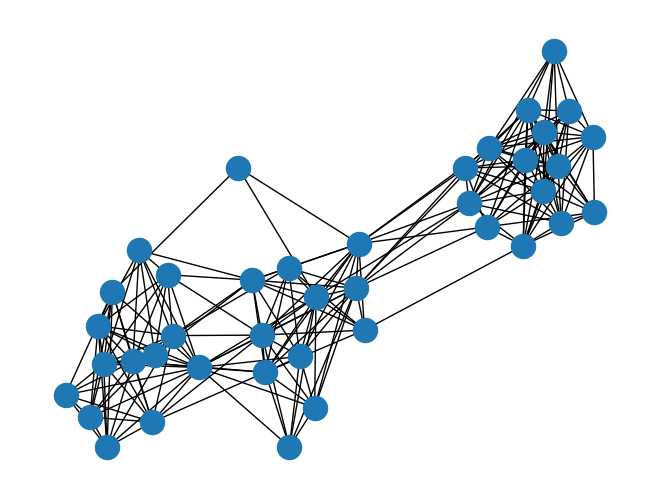

In [ ]:
dataset.draw_subGraph(list(res))

[  1   4   8   9  15  34  35  41  63  66  96 102 126]


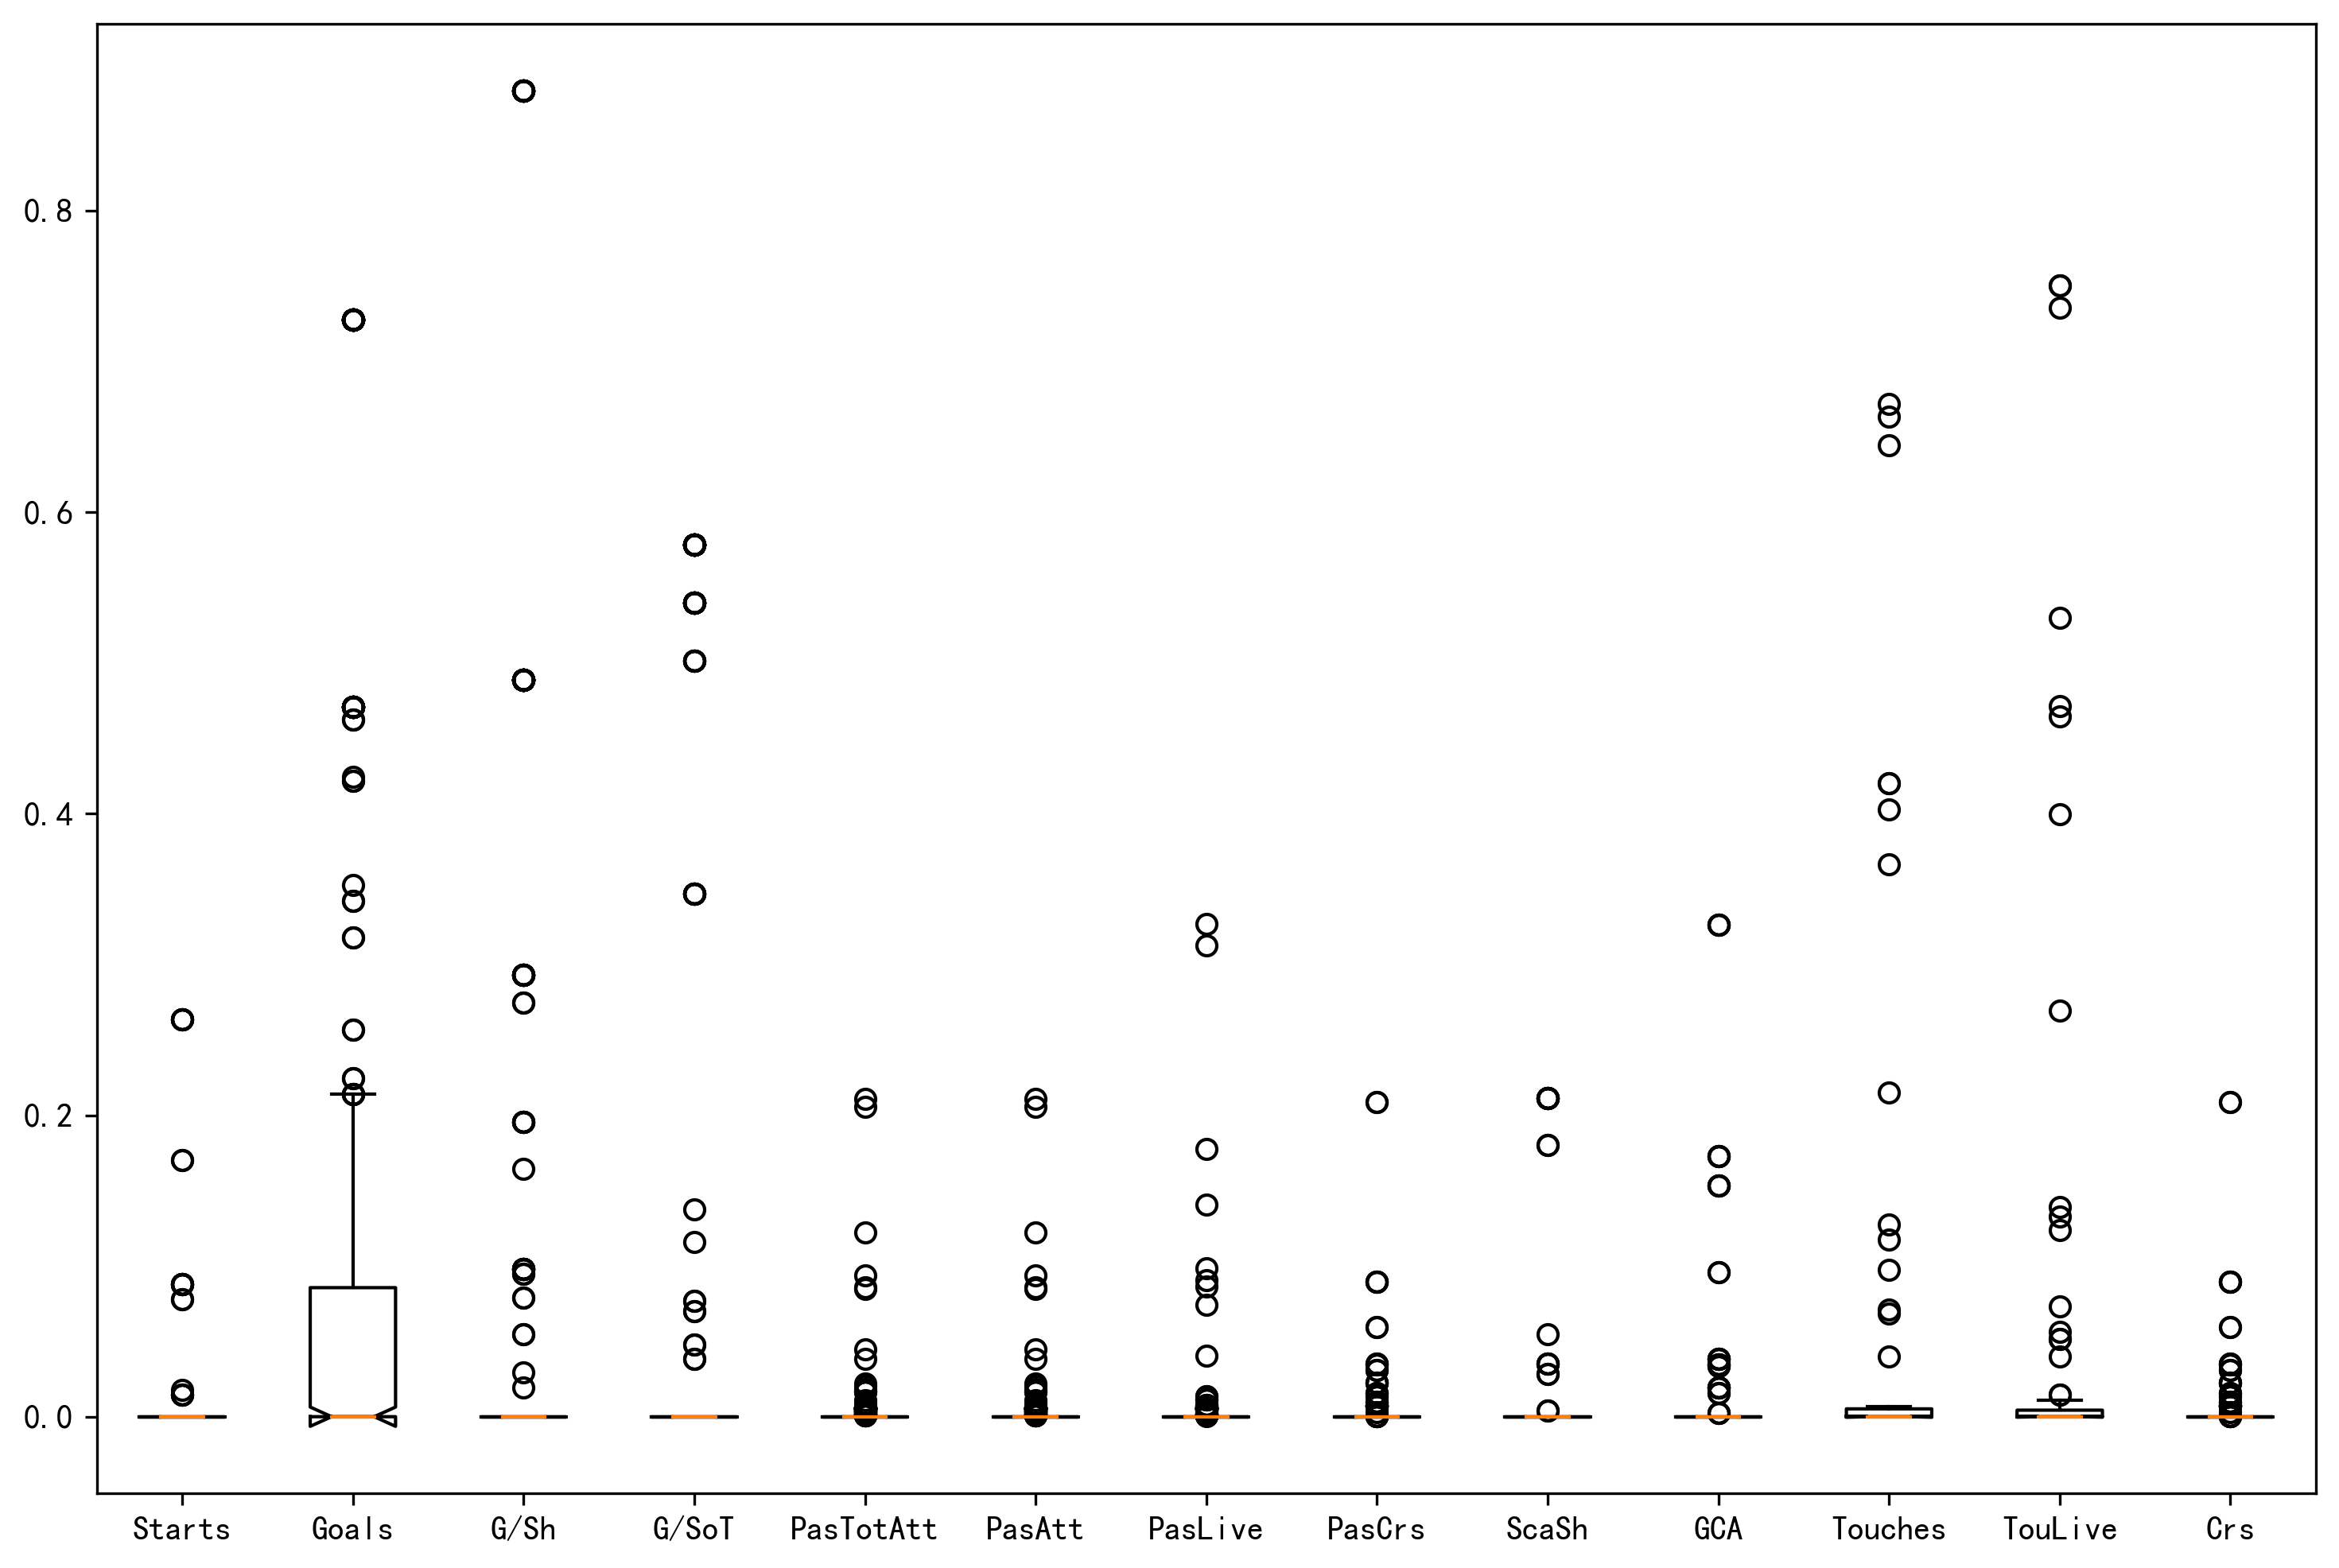

In [ ]:
idx = np.nonzero(cluster_pair_differs_l.max(axis=0) > 0.2)[0]  # 选出大于0.02的特征，得到的global idx
print(idx)
values = cluster_pair_differs_l[:, idx]   # 选出这些特征的原始数据，它们被认为是在这个空洞中显著存在差异的特征
# 想用中文必须进行设置RC参数
plt.rcParams['font.sans-serif'] = 'SimHei'
# 设置RC参数字体，让其支持中文
plt.rcParams['axes.unicode_minus'] = False
# 加载数据
# 创建画布
plt.figure(dpi=300,figsize=(12,8))
labels = [dataset.index2col[i] for i in idx]
# notch --缺口 meanline --均值线
plt.boxplot(values, meanline=True, notch=True, labels=labels)  # x size [raw, features]
plt.show()


In [ ]:
print(values.shape)
cors = np.corrcoef(values.T) # 要求输入的shape [nfeatures, nsamples]
print(cors.shape)
#print(cors)
significant_correlate = []
for raw in np.argwhere(cors < -0.2):
    if raw[0] > raw[1]:
        significant_correlate.append((raw, cors[raw[0]][raw[1]]))

print(significant_correlate)
for raw, pearson in significant_correlate:
    print(dataset.index2col[idx[raw[0]]], dataset.index2col[idx[raw[1]]], round(pearson, 3))

# 我似乎关联挖掘的方法有错误，这种方法找到的高度相关的两个变量，往往只是含义相近，而不是vacancy
# 似乎是负相关？此消彼长？？orzzz 数学直觉一点都不剩了，我做的这些东西除了直觉还剩什么吗？没有力
# xs，make sense了，但是meaningless

(441, 13)
(13, 13)
[]


In [ ]:
# 在这个局部的投影下，没看到明显的空洞结构orzzz
# 换一下umap？

from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
#pca = PCA(n_components=3)
#values = pca.fit_transform(values)
origin_values = dataset.X_features_numeric[member_l, :][:, np.array([12,  13, 111])]
plot_point_cloud(origin_values)


In [ ]:
origin_values.shape

(354, 3)

In [ ]:
a, df = dataset.get_members(res)
# 先求出点云的最中心位置
# 后面一步，我的想法是，不是求最小化cos值的，而是计算让cos值小于一定范围的
(df.values - df.values.mean(axis=0)).shape


ValueError: too many values to unpack (expected 2)

In [ ]:
cen = np.array([v for k, v in dataset.closeCenResult.items()])
print(cen.mean())
print(cen.std())
scaler = StandardScaler()
re = scaler.fit_transform(cen.reshape(-1, 1))
count, seper = np.histogram(re, bins=10)
print(seper)
print(re[0])
print((seper < re[0]).sum()+1)
re.sort(axis=0)
bins = np.array_split(re, 10)
bin_counts = np.array([b.min() for b in bins])
print(bin_counts)  # 每个区间的个数
#print(bins)


In [ ]:
cen = np.array([v for k, v in dataset.closeCenResult.items()])
print(cen.mean())
print(cen.std())
plt.hist(cen)
plt.show()

In [ ]:
scaler = StandardScaler()
re = scaler.fit_transform(cen.reshape(-1, 1))
print(re.mean())
print(re.std())
plt.hist(re)
plt.show()